Imamo dataset koji sadrži informacije o određenom broju osoba koje mogu biti relevantne u predikciji da li je ta osoba sklona tome da ima srčani udar ili ne. Moj zadatak je da na osnovu datih podataka naučim, istreniram i  predvidim da li je osoba sklona tome da ima srčani udar ili ne.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import sklearn.metrics as metrics

In [3]:
data = pd.read_csv("data.csv")
# prikaz prvih 10 redova
data.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
5,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
6,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
7,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
8,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
9,12109,Female,81.0,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1


Eksploracija podataka i priprema


In [4]:

# Lista varijabli za Label Encoding
label_encode_vars = ['ever_married', 'Residence_type']

# Funkcije za Label Encoding
def label_encode(df, columns):
    for col in columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0}) if col == 'ever_married' else df[col].map({'Urban': 1, 'Rural': 0})
    return df

data = label_encode(data, label_encode_vars)

# Lista varijabli za Ordinal Encoding
ordinal_encode_vars = ['work_type']
ordinal_map = {
    'Private': 4,
    'Self-employed': 3,
    'Govt_job': 2,
    'children': 1,
    'Never_worked': 0
}

# Funkcija za Ordinal Encoding
def ordinal_encode(df, columns, mapping):
    for col in columns:
        df[col] = df[col].map(mapping)
    return df

data = ordinal_encode(data, ordinal_encode_vars, ordinal_map)

# Lista varijabli za One-Hot Encoding
one_hot_encode_vars = ['smoking_status', 'gender']

# One-Hot Encoding
data = pd.get_dummies(data, columns=one_hot_encode_vars)


In [5]:
# Brisanje NaN vrijednosti, inače će se pogrešno trenirati i dati veoma loše preciznosti i rezultate evaluacije
data = data.dropna(subset=['bmi'])
print(data.head())

      id   age  hypertension  heart_disease  ever_married  work_type  \
0   9046  67.0             0              1             1          4   
2  60182  49.0             0              0             1          4   
3   1665  79.0             1              0             1          3   
4  56669  81.0             0              0             1          4   
5  53882  74.0             1              1             1          4   

   Residence_type  avg_glucose_level   bmi  stroke  smoking_status_Unknown  \
0               1             228.69  36.6       1                   False   
2               1             171.23  34.4       1                   False   
3               0             174.12  24.0       1                   False   
4               1             186.21  29.0       1                   False   
5               0              70.09  27.4       1                   False   

   smoking_status_formerly smoked  smoking_status_never smoked  \
0                            Tru

In [6]:
# Funkcija za mješanje čitavog dataseta
def shuffle_df(df):
    return df.sample(frac=1, random_state=0).reset_index(drop=True)

data_shuffled = shuffle_df(data)

In [8]:
from sklearn.model_selection import train_test_split
# Podjela na train i test skup
X = data_shuffled.drop('stroke', axis=1)
y = data_shuffled['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:

from sklearn.preprocessing import StandardScaler


# Sačuvajmo originalne DataFrame-ove za analize
df_train_original = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
df_test_original = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# Normaliziranje podataka
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Učenje i transformacija obučavajućih podataka
X_test_scaled = scaler.transform(X_test)        # Transformacija testnih podataka na osnovu učenja iz X_train

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (3692, 16)
X_test_scaled shape: (924, 16)


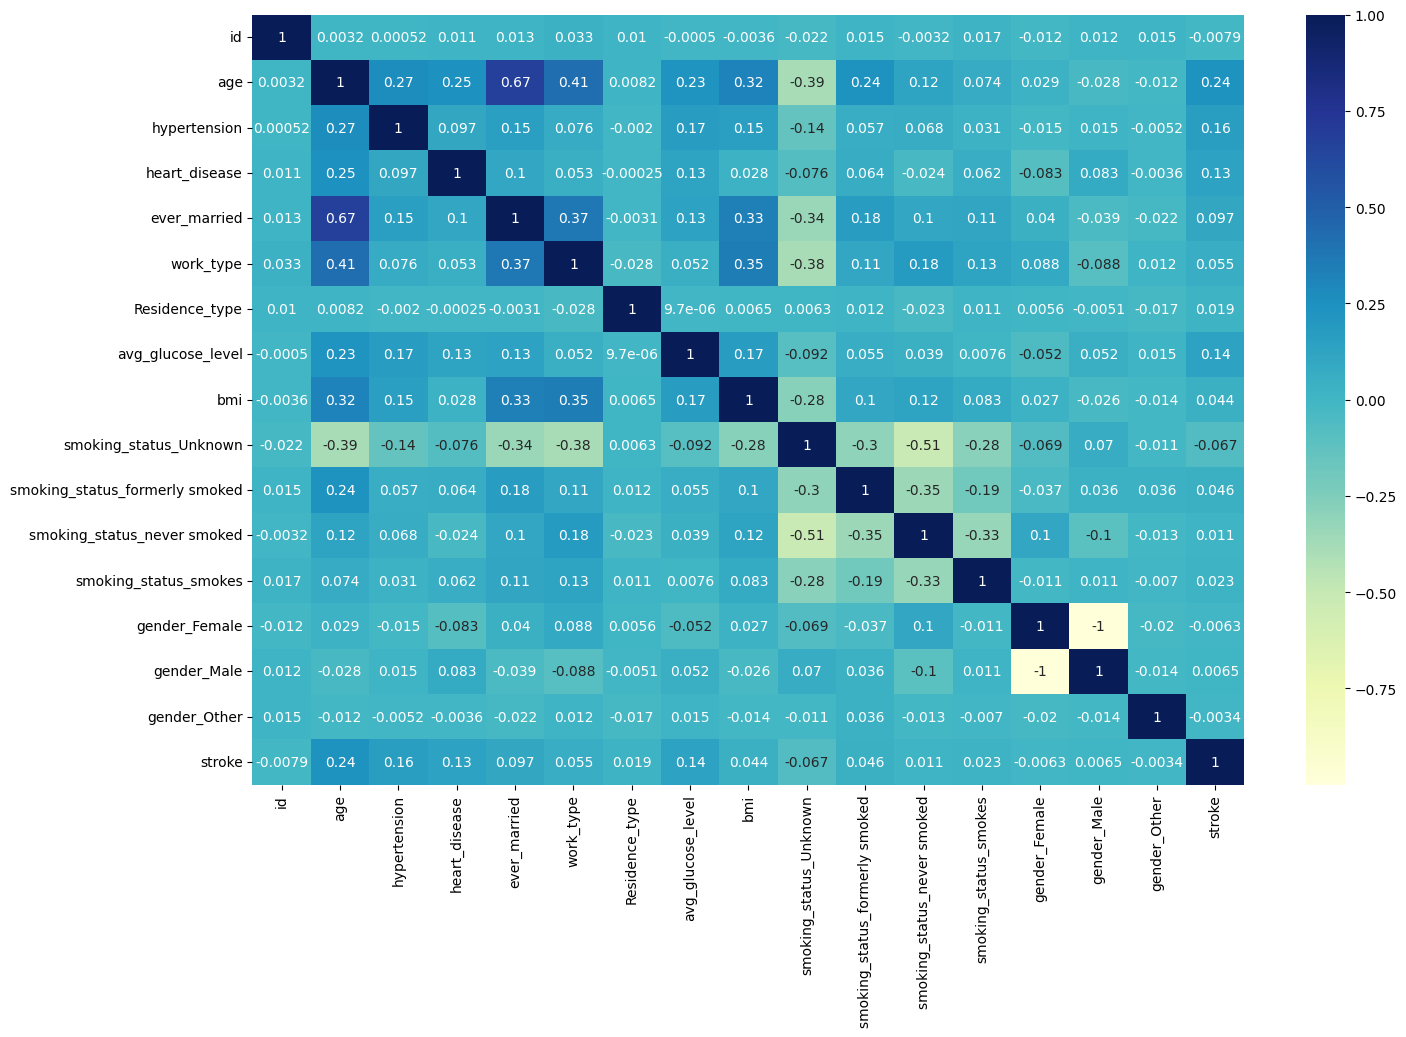

In [10]:
# Matrica korelacije koja nam daje informacije o tome koje su kolone povezane, bitne i imaju uticaj na predviđanje
# Vidimo da je to age i ever_married jer starost je čest uzrok bolesti
corr_matrix = df_train_original.corr()

plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.show()


In [11]:
# ISPRAVNA VERZIJA

# Pošto su podaci nebalansirani za klasu 0, uradićemo oversamplovanje da bi dobili bolje rezultate treniranja i testiranja.
# Postoji šansa, ukoliko se primjeni oversampling, da dođe do overfittovanja podataka. Oversampla se samo trening skup

from imblearn.over_sampling import SMOTE

# Primjena SMOTE oversamplinga na trening skup
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


# Pretvaranje y_train_resampled u pandas seriju
y_train_resampled_series = pd.Series(y_train_resampled)

# Prikaz rezultata
print("Broj pojavljivanja klasa nakon oversamplinga:")
print(y_train_resampled_series.value_counts())

Broj pojavljivanja klasa nakon oversamplinga:
stroke
0    3538
1    3538
Name: count, dtype: int64


In [12]:
# Brojanje pojavljivanja vrijednosti u određenoj koloni
count_values = data['stroke'].value_counts()

# Ispis broja pojavljivanja svake vrijednosti
print(count_values)
#Zbog ovoga smo radili overfitting jer podaci su nebalansirani i super će se istrenirati i evaluirati za vrijednost izlazne varijable kada je 0 ali problem nastaje kada je vrijednost 1
# Tako smo dobili vještačke podatke i poboljšali naš model

stroke
0    4421
1     195
Name: count, dtype: int64


In [13]:
# Ukoliko se svm model obuči sa SMOTE i ne primjeni parametar C  ili zadaju neke vrijednosti, tada se dešava sljedeće :
# Precision je za klasu 0 0.99 a za klasu 1 0.12 dok recall je približno (0.72 i 0.80 respektivno), f1-score (0.84 i 0.21)
# Međutim ako se primjeni regularizacijski faktor C = 10e-6, tada se podaci mjenjaju.
# Podaci se lošije predviđaju za klasu 1 nego za klasu 0 tj razlika za recall između klasa je veća kao i za f1-score dok je precision ostao prilično isti
# Ovo je posljedica nebalansiranog dataseta


from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Inicijalizacija SVM modela s regularizacijskim parametrom
svm_weighted = SVC(kernel='linear', C=1e-6, class_weight='balanced')  # Postavite class_weight na 'balanced'

# Treniranje modela na oversampled podacima
svm_weighted.fit(X_train_resampled, y_train_resampled)

# Predikcija na testnom skupu s originalnim podacima
y_pred_test = svm_weighted.predict(X_test_scaled)

# Evaluacija modela na testnom skupu
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy sa originalnim test podacima:", accuracy_test)

# Ispis detaljnijeg izvještaja o klasifikaciji sa originalnim test podacima
print(classification_report(y_test, y_pred_test))

Accuracy sa originalnim test podacima: 0.816017316017316
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       883
           1       0.14      0.61      0.23        41

    accuracy                           0.82       924
   macro avg       0.56      0.72      0.56       924
weighted avg       0.94      0.82      0.87       924



Grafici za SVM pri čemu je primjenjen SMOTE


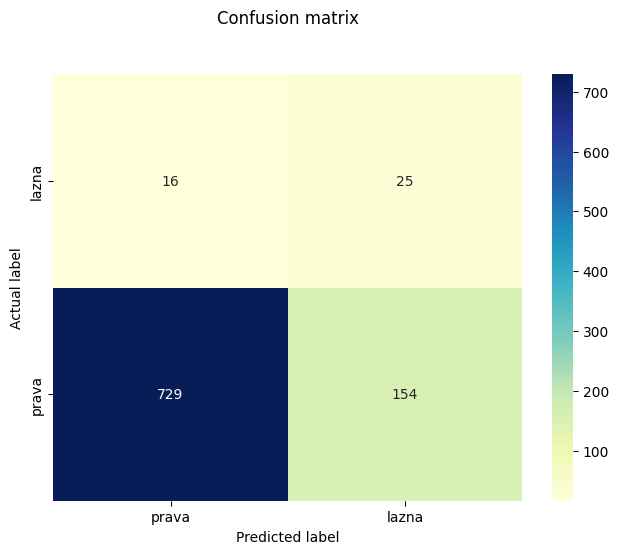

In [14]:
# Matrica konfuzije je osnovni alat za evaluaciju performansi modela klasifikacije. Ona prikazuje stvarne i predviđene klase za skup podataka.
# Matrica konfuzije omogućava procjenu gdje model griješi i može biti korisna za razumijevanje performansi modela.
# Na primjer, možete vidjeti koliko često model zbunjuje jednu klasu s drugom, ili koliko često neuspješno prepoznaje određenu klasu.
# Model je dobro istreniran jer 842 pravih(tačnih) je prepoznao kao prave, kao i 5 lažnih je ispravno klasificirao kao lažne
# Model nema mnogo grešaka zato su vrijednosti u žutim poljima niske
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the Confusion Matrix as a HeatMap
class_names=["prava", "lazna"] # Name  of classes
fig, ax = plt.subplots()

# Generiranje matrice konfuzije
conf_matrix_resampled = confusion_matrix(y_test,y_pred_test)

# create heatmap
sns.heatmap(pd.DataFrame(conf_matrix_resampled), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
ax.invert_yaxis()
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.show()


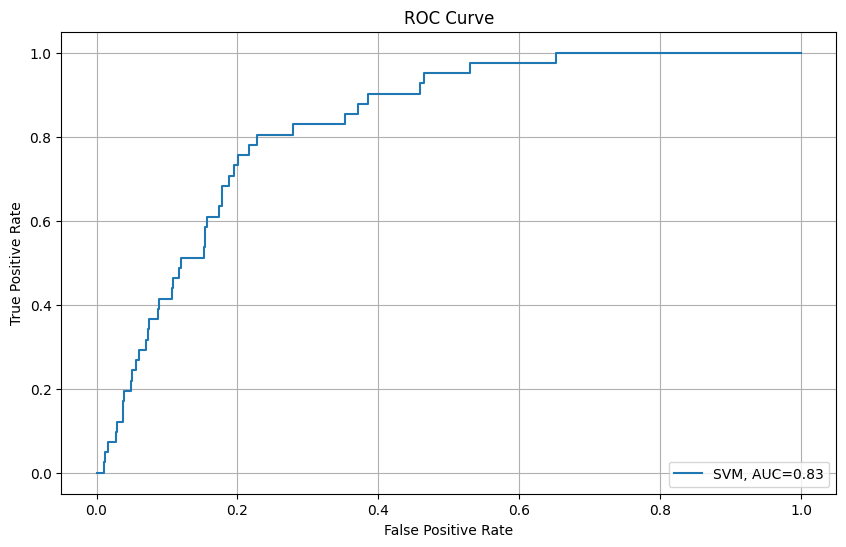

AUC Score: 0.83
The AUC Score provides an aggregate measure of performance across all possible classification thresholds.
AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.


In [15]:
# ROC (Receiver Operating Characteristic) krivulja je graf koji prikazuje performanse binarnog klasifikatora na svim pragovima odluke.
# ROC kriva prikazuje odnos između stope lažno pozitivnih rezultata (False Positive Rate - FPR) i stope istinito pozitivnih rezultata (True Positive Rate - TPR) za različite pragove odluke.
# Bitna je površina ispod te krive i ona treba da teži ka 1 što bi značilo da naš model tada bi pravio ili male ili nikakve greške
# U našem slučaju, površina je 0.83 što je zadovoljavajuće jer će samo u 20% slučajeva pogriješiti, kriva stabilno se približava 1

#Threshold je prag koji model koristi za klasifikaciju. Na primjer, ako je prag 0.5, sve instance sa vjerovatnoćom
# većom od 0.5 biće klasifikovane kao pozitivne, dok će one sa vjerovatnoćom manjom od 0.5 biti klasifikovane kao negativne.
# ROC kriva prikazuje performanse modela za sve moguće pragove, od 0 do 1, i kako se mijenja odnos između TPR i FPR pri promjeni praga.

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Pretpostavljamo da je svm_weighted model obučen na oversampled trening podacima

# Izračunajte vjerojatnosti pripadnosti pozitivnoj klasi za neoversamplovane test podatke
y_pred_proba = svm_weighted.decision_function(X_test_scaled)

# Izračunajte FPR i TPR
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Izračunajte AUC
auc = roc_auc_score(y_test, y_pred_proba)

# Crtanje ROC krivulje
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="SVM, AUC=" + str(round(auc, 2)))
plt.legend(loc="lower right")
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# Ispis AUC-a
print('AUC Score:', round(auc, 2))
print('The AUC Score provides an aggregate measure of performance across all possible classification thresholds.')
print('AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.')


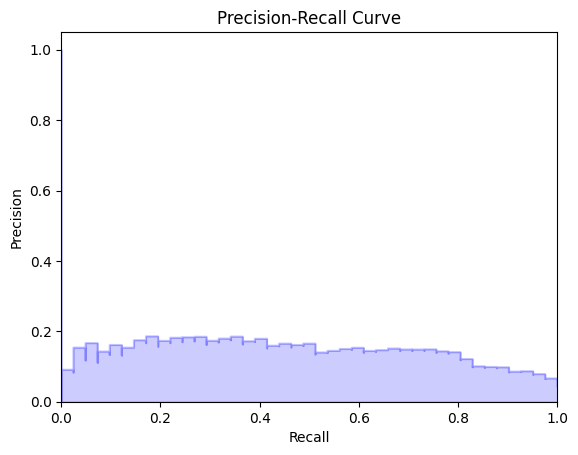

In [16]:
# Površina ispod krive je niska jer je dataset nebalansiran
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Izračunaj vjerojatnosti pripadanja klasama
y_scores = svm_weighted.decision_function(X_test_scaled)

# Izračunaj preciznost i odziv
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Nacrtaj Precision-Recall krivulju
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show()


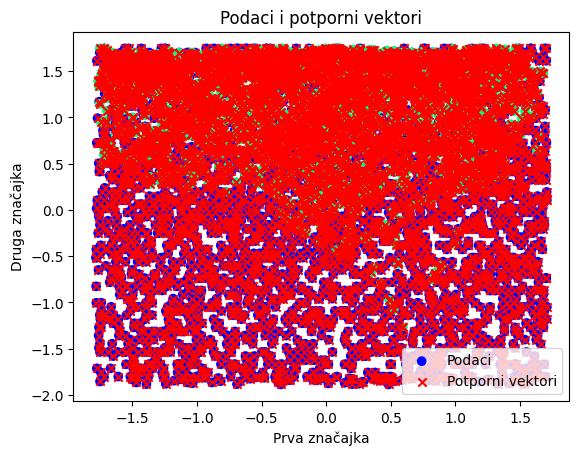

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Izdvojite potporne vektore
support_vectors = svm_weighted.support_vectors_

# Prikaz podataka i potpornih vektora u grafikonu
plt.scatter(X_train_resampled[:, 0], X_train_resampled[:, 1], c=y_train_resampled, cmap='winter', label='Podaci')
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], color='red', marker='x', label='Potporni vektori')
plt.xlabel('Prva značajka')
plt.ylabel('Druga značajka')
plt.title('Podaci i potporni vektori')
plt.legend()
plt.show()


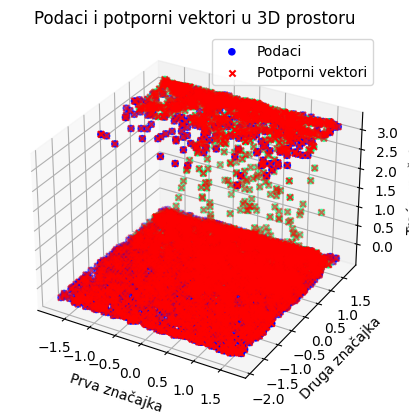

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Izdvojite potporne vektore
support_vectors = svm_weighted.support_vectors_

# Prikaz podataka i potpornih vektora u 3D grafikonu
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Prikaz podataka
ax.scatter(X_train_resampled[:, 0], X_train_resampled[:, 1], X_train_resampled[:, 2], c=y_train_resampled, cmap='winter', label='Podaci')

# Prikaz potpornih vektora
ax.scatter(support_vectors[:, 0], support_vectors[:, 1], support_vectors[:, 2], color='red', marker='x', label='Potporni vektori')

ax.set_xlabel('Prva značajka')
ax.set_ylabel('Druga značajka')
ax.set_zlabel('Treća značajka')
ax.set_title('Podaci i potporni vektori u 3D prostoru')
ax.legend()

plt.show()


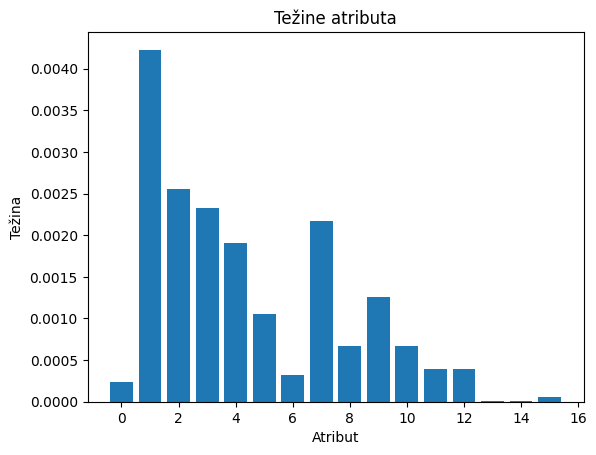

In [19]:
# Dobivanje apsolutnih vrijednosti težina atributa
# Ovdje vidimo da najveću težinu nosi atribut age što smo vidjeli sa linearne korelacije i kao sa selection feature
absolute_weights = np.abs(svm_weighted.coef_)

# Prikaz težina atributa u bar grafikonu
plt.bar(range(len(absolute_weights[0])), absolute_weights[0])
plt.xlabel('Atribut')
plt.ylabel('Težina')
plt.title('Težine atributa')
plt.show()


SVM oversampled preko SVMSMOTE


In [20]:
from imblearn.over_sampling import SVMSMOTE

# Primjena SVMSMOTE oversamplinga na trening skup
svmsmote = SVMSMOTE(random_state=42)
X_train_resampled, y_train_resampled = svmsmote.fit_resample(X_train_scaled, y_train)



In [24]:
# Ukoliko se svm model obuči sa SVMSMOTE i ne primjeni parametar C:
# Omjer precision za 0 i 1 : (0.98, 0.16), recall je blizu, f1-score (0.90 i 0.26)
# Međutim ako se primjeni regularizacijski faktor C = 10e-6, tada se podaci previše reguliraju pa za klasu 1 svi podacu budu 0, dok je za klasu 0 recall 100%.
# Za C = 10e-5, neprimjetna promjena za precision,  recall je sada jako daleko (0.95 i 0.24)
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Inicijalizacija SVM modela s težinama klasa
svm_weighted = SVC(kernel='linear',C=10e-5)

# Treniranje modela na oversampled podacima
svm_weighted.fit(X_train_resampled, y_train_resampled)  # Koristimo podatke nakon oversamplinga

# Predikcija na testnom skupu s oversampled podacima
y_pred_test= svm_weighted.predict(X_test_scaled)

# Evaluacija modela na testnom skupu s oversampled podacima
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy sa oversamplovanim test podacima:", accuracy_test)

# Ispis detaljnijeg izvještaja o klasifikaciji s oversampled test podacima
# Ispis izvještaja o klasifikaciji s zero_division parametrom
print(classification_report(y_test, y_pred_test, zero_division=0))

# Model nije ni overfittovan ni underfittovan. Promjenom hiperparametara, predviđanje se može poboljšati. Takođe može se primjeniti i undersampling ali onda može doći do gubitka važnih informacija.
# Možemo primjeniti umjesto oversamplinga i undersamplinga, svm sa težinama na način da parametar class_weight postavimo na "balanced"
# Automatski se računaju težine kako bi bile obrnuto proporcionalne broju uzoraka u svakoj klasi. Na taj način, SVM će uzeti u obzir neuravnoteženost klasa prilikom učenja.



Accuracy sa oversamplovanim test podacima: 0.9166666666666666
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       883
           1       0.18      0.24      0.21        41

    accuracy                           0.92       924
   macro avg       0.57      0.60      0.58       924
weighted avg       0.93      0.92      0.92       924



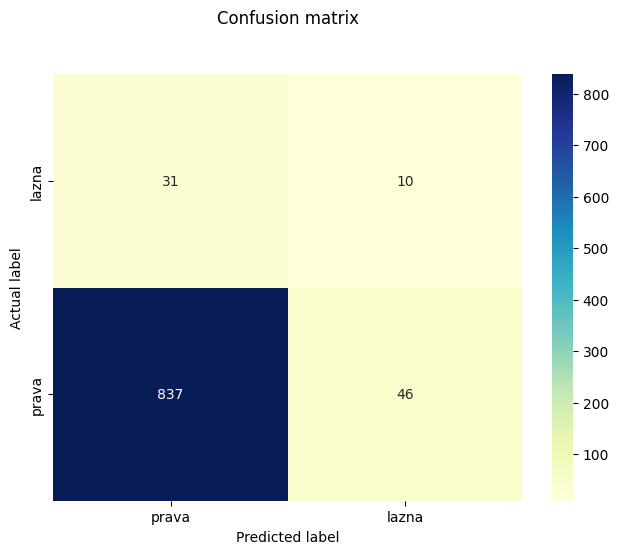

In [26]:
# Matrica konfuzije je osnovni alat za evaluaciju performansi modela klasifikacije. Ona prikazuje stvarne i predviđene klase za skup podataka.
# Matrica konfuzije omogućava procjenu gdje model griješi i može biti korisna za razumijevanje performansi modela.
# Na primjer, možete vidjeti koliko često model zbunjuje jednu klasu s drugom, ili koliko često neuspješno prepoznaje određenu klasu.
# Model nije toliko dobro istreniran jer 837 pravih(tačnih) je prepoznao kao prave, kao i 10 lažnih je ispravno klasificirao kao lažne
# Model nema mnogo grešaka zbog toga su "niske" vrijednosti u žutim poljima
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the Confusion Matrix as a HeatMap
class_names=["prava", "lazna"] # Name  of classes
fig, ax = plt.subplots()

# Generiranje matrice konfuzije
conf_matrix= confusion_matrix(y_test, y_pred_test)

# create heatmap
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
ax.invert_yaxis()
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.show()

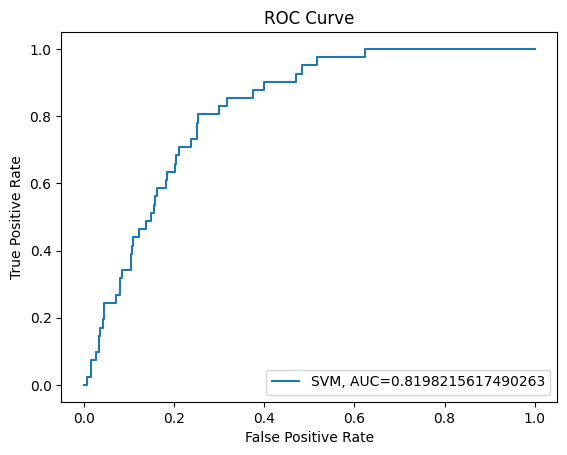

AUC Score: 0.8198215617490263
The AUC Score provides an aggregate measure of performance across all possible classification thresholds.
AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct


In [27]:
# ROC (Receiver Operating Characteristic) krivulja je graf koji prikazuje performanse binarnog klasifikatora na svim pragovima odluke.
# ROC kriva prikazuje odnos između stope lažno pozitivnih rezultata (False Positive Rate - FPR) i stope istinito pozitivnih rezultata (True Positive Rate - TPR) za različite pragove odluke.
# Bitna je površina ispod te krive i ona treba da teži ka 1 što bi značilo da naš model tada bi pravio ili male ili nikakve greške
# U našem slučaju, površina je 0.81 što je zadovoljavajuće jer će samo u 20% slučajeva pogriješiti, kriva stabilno se približava 1

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Izračunajte vjerojatnosti pripadnosti pozitivnoj klasi
y_pred_proba = svm_weighted.decision_function(X_test_scaled)

# Izračunajte FPR i TPR
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Izračunajte AUC
auc = roc_auc_score(y_test, y_pred_proba)

# Crtanje ROC krivulje
plt.plot(fpr, tpr, label="SVM, AUC=" + str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Ispis AUC-a
print('AUC Score:', auc)
print('The AUC Score provides an aggregate measure of performance across all possible classification thresholds.')
print('AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct')

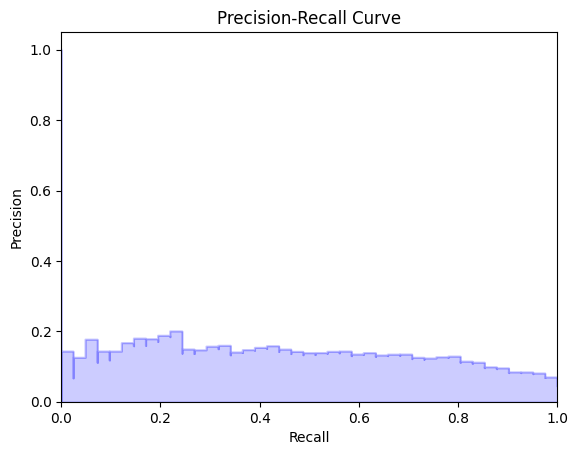

In [28]:
# Odavdje vidimo da smo dobro izbalansirali model jer su preciznost i recall usko bliski i površina ispod krive je dosta visoka ali su rezultati bolji za SMOTE

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Izračunaj vjerojatnosti pripadanja klasama
y_scores = svm_weighted.decision_function(X_test_scaled)

# Izračunaj preciznost i odziv
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Nacrtaj Precision-Recall krivulju
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show()

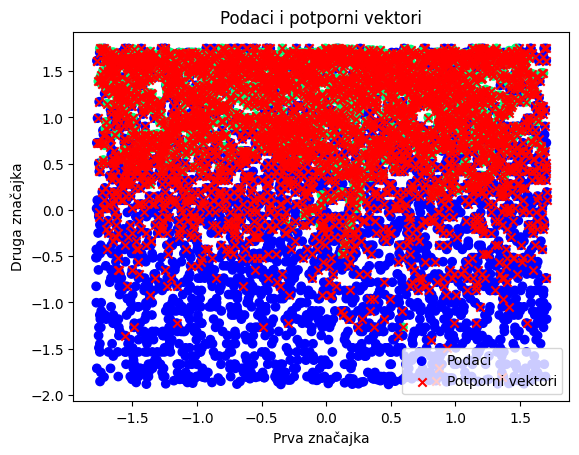

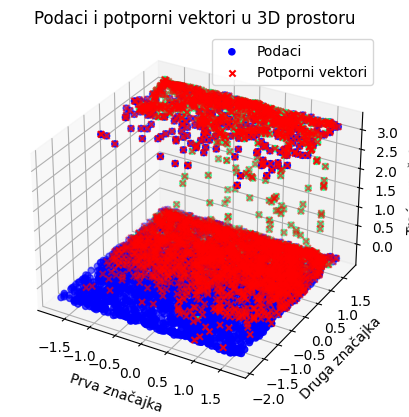

In [29]:

import numpy as np
import matplotlib.pyplot as plt

# Izdvojite potporne vektore
support_vectors = svm_weighted.support_vectors_

# Prikaz podataka i potpornih vektora u grafikonu
plt.scatter(X_train_resampled[:, 0], X_train_resampled[:, 1], c=y_train_resampled, cmap='winter', label='Podaci')
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], color='red', marker='x', label='Potporni vektori')
plt.xlabel('Prva značajka')
plt.ylabel('Druga značajka')
plt.title('Podaci i potporni vektori')
plt.legend()
plt.show()



import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Izdvojite potporne vektore
support_vectors = svm_weighted.support_vectors_

# Prikaz podataka i potpornih vektora u 3D grafikonu
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Prikaz podataka
ax.scatter(X_train_resampled[:, 0], X_train_resampled[:, 1], X_train_resampled[:, 2], c=y_train_resampled, cmap='winter', label='Podaci')

# Prikaz potpornih vektora
ax.scatter(support_vectors[:, 0], support_vectors[:, 1], support_vectors[:, 2], color='red', marker='x', label='Potporni vektori')

ax.set_xlabel('Prva značajka')
ax.set_ylabel('Druga značajka')
ax.set_zlabel('Treća značajka')
ax.set_title('Podaci i potporni vektori u 3D prostoru')
ax.legend()

plt.show()


Selekcija features(RFE)


In [30]:
# Preko linearne korelacije, preko težine atributa a i RFE vidimo da age je zaista najbitnija značajka
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

num_features = X_train_scaled.shape[1]  # Broj značajki u tvojim podacima
selected_features_indices = None

for i in range(num_features):
    logistic_reg = LogisticRegression()
    rfe = RFE(logistic_reg, n_features_to_select=num_features-i)  # running RFE
    rfe = rfe.fit(X_train_scaled, y_train)
    selected_features_indices = np.where(rfe.support_)[0]
    second_column_name = data.columns[selected_features_indices]
    print(f"\nNumber of retained features: {num_features - i}")
    print("Ime featurea:", second_column_name)



Number of retained features: 16
Ime featurea: Index(['id', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'stroke',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes', 'gender_Female',
       'gender_Male'],
      dtype='object')

Number of retained features: 15
Ime featurea: Index(['id', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'stroke',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes', 'gender_Male'],
      dtype='object')

Number of retained features: 14
Ime featurea: Index(['id', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'stroke',
       'smoking_status_Unknown', 'smoking_status_formerly smoked

NEURALNE MREŽE


In [40]:
import tensorflow as tf
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Normalizacija podataka
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Učenje i transformacija obučavajućih podataka

# Primjena SMOTE oversamplinga na trening skup
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Transformacija test podataka koristeći istu normalizaciju kao za obučavajuće podatke
X_test_scaled = scaler.transform(X_test)  # Transformacija testnih podataka na osnovu učenja iz X_train

# Definiranje modela s dodatnim slojevima i dropout-om
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Callback za praćenje performansi i ranog zaustavljanja
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Treniranje modela
history = model.fit(X_train_resampled, y_train_resampled,
                    epochs=90,
                    batch_size=80,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=callbacks)

# Ispis arhitekture modela
print("Model Architecture:")
model.summary()

# Evaluacija modela
loss, accuracy, precision, recall = model.evaluate(X_test_scaled, y_test)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Epoch 1/90


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5066 - loss: 0.7344 - precision_9: 0.5120 - recall_9: 0.5952 - val_accuracy: 0.7273 - val_loss: 0.6094 - val_precision_9: 0.1136 - val_recall_9: 0.7561
Epoch 2/90
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6300 - loss: 0.6327 - precision_9: 0.6356 - recall_9: 0.6175 - val_accuracy: 0.7110 - val_loss: 0.4821 - val_precision_9: 0.1156 - val_recall_9: 0.8293
Epoch 3/90
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7109 - loss: 0.5569 - precision_9: 0.6969 - recall_9: 0.7420 - val_accuracy: 0.6656 - val_loss: 0.4635 - val_precision_9: 0.1036 - val_recall_9: 0.8537
Epoch 4/90
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7532 - loss: 0.5117 - precision_9: 0.7209 - recall_9: 0.8234 - val_accuracy: 0.6374 - val_loss: 0.4529 - val_precision_9: 0.0962 - val_recall_9: 0.8537
Epoch 5/90
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7693 - loss: 0.4763 - precision_9: 0.7258 - recall_9: 0.8708 - val_accuracy: 0.665

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_46 (Dense)                     │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 13,633 (53.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,268 (106.52 KB)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7276 - loss: 0.3665 - precision_9: 0.1315 - recall_9: 0.9111
Loss: 0.3950701653957367
Accuracy: 0.698051929473877
Precision: 0.11612903326749802
Recall: 0.8780487775802612
